In [1]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord
from inverse_covariance import QuicGraphicalLasso
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri

# utils
import sys
sys.path.append('../utils')
from utils import partial_corr, tp_fp, mcc, precision_recall, pseudo_BIC, gauss_BIC, proj_precision_mat, newton_one_step
from generate_graphs import generate_erdos_renyi, generate_data

In [2]:
# select graph structure = ['hub_network', 'erdos_renyi']
graph_structure = 'hub_network'

### Generate graph and data

In [3]:
if graph_structure == 'hub_network':
    # we use pre-made hub-network graph structure, which was constructed by the following procedure:
    # (1) create a Barabasi-Albert scale-free graph
    # (2) randomly choose 5% of the nodes to be hub nodes
    # (3) for each hub node, construct a complete sub-graph (clique)
    Skel = np.genfromtxt('../data/hub_network_structure.txt', delimiter=',')

    n, p = 500, 1000
    n_prop_to_p = [0.5]
    random_state = 2023
    lower_weight, upper_weight = 0.5, 1.0

    # projection method
    np.random.seed(random_state)
    edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
    edge_signs = np.random.choice([-1,1], size=(p,p))
    Theta = np.multiply(edge_weights, edge_signs)
    Theta = np.multiply(Skel, Theta)
    Theta = np.tril(Theta) + np.tril(Theta).T
    nz_indx = np.nonzero(Theta)
    for i in range(100):
        Theta = proj_precision_mat(Theta, nz_indx)
        if np.linalg.cond(Theta) < 20:
            break

    Theta = np.real(Theta)
    # spread diagonal of precision matrix
    spread_diag=[1, 3]
    d = np.random.uniform(spread_diag[0], spread_diag[1], p)
    Theta = np.diag(d) @ Theta @ np.diag(d)
    Rho = partial_corr(Theta)
    Sigma = np.linalg.inv(Theta)

    Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
    X = Xs[0]

elif graph_structure == 'erdos_renyi':
    n, p = 500, 1000
    n_prop_to_p = [0.5]
    Theta, Sigma = generate_erdos_renyi(p, type='proj', edge_prob=0.01, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, 3], random_state=2023)
    Rho = partial_corr(Theta)

    Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
    X = Xs[0]

### Run ACCORD, CONCORD, Glasso

In [4]:
S = np.matmul(X.T, X)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)

if graph_structure == 'hub_network':
    # lams = lams[::-1][14:26] # pre-selected lambdas for hub network
    lams = lams[::-1]
elif graph_structure == 'erdos_renyi':
    # lams = lams[::-1][7:19] # pre-selected lambdas for erdos renyi
    lams = lams[::-1]

random_state = 2023
np.random.seed(random_state)
for lam in lams:
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=100)
    model.fit(X)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
    pseudo_p_bic = pseudo_BIC(X, Theta_hat, modified=False, gamma=0)
    pseudo_ep_bic = pseudo_BIC(X, Theta_hat, modified=True, gamma=0.2)
    tp, fp = tp_fp(Theta, Theta_hat)
    prec, recall = precision_recall(Theta, Theta_hat)
    print('lam:', np.round(lam, 3), ', TP:', tp, ', FP:', fp,\
           ', MCC:', np.round(mcc(Theta, Theta_hat),2),\
           'Precision:', np.round(prec,2),\
           'Recall:', np.round(recall,2),\
           ', pBIC:', np.round(pseudo_p_bic, 2),\
           ', epBIC:', np.round(pseudo_ep_bic, 2))

lam: 0.401 , TP: 0 , FP: 0 , MCC: 0.0 Precision: nan Recall: 0.0 , pBIC: 533904.59 , epBIC: 533904.59
lam: 0.37 , TP: 0 , FP: 0 , MCC: 0.0 Precision: nan Recall: 0.0 , pBIC: 529118.15 , epBIC: 529118.15
lam: 0.342 , TP: 0 , FP: 0 , MCC: 0.0 Precision: nan Recall: 0.0 , pBIC: 524963.97 , epBIC: 524963.97
lam: 0.316 , TP: 2 , FP: 0 , MCC: 0.02 Precision: 1.0 Recall: 0.0 , pBIC: 521345.6 , epBIC: 521356.66
lam: 0.292 , TP: 19 , FP: 0 , MCC: 0.06 Precision: 1.0 Recall: 0.0 , pBIC: 518217.53 , epBIC: 518322.53
lam: 0.269 , TP: 99 , FP: 0 , MCC: 0.14 Precision: 1.0 Recall: 0.02 , pBIC: 515136.46 , epBIC: 515683.55
lam: 0.249 , TP: 249 , FP: 0 , MCC: 0.22 Precision: 1.0 Recall: 0.05 , pBIC: 511481.72 , epBIC: 512857.75
lam: 0.23 , TP: 552 , FP: 0 , MCC: 0.33 Precision: 1.0 Recall: 0.11 , pBIC: 506996.12 , epBIC: 510046.58
lam: 0.212 , TP: 1000 , FP: 1 , MCC: 0.45 Precision: 1.0 Recall: 0.2 , pBIC: 500813.44 , epBIC: 506345.18
lam: 0.196 , TP: 1503 , FP: 6 , MCC: 0.55 Precision: 1.0 Recall: 0.

In [4]:
accord_edges, accord_precs, accord_recalls, accord_mccs = [], [], [], []
concord_edges, concord_precs, concord_recalls, concord_mccs = [], [], [], []
glasso_edges, glasso_precs, glasso_recalls, glasso_mccs = [], [], [], []

accord_p_bics, accord_ep_bics_02, accord_g_bics = [], [], []
concord_p_bics, concord_ep_bics_02 = [], []
glasso_g_bics = []

S = np.matmul(X.T, X)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
if graph_structure == 'hub_network':
    lams = lams[::-1][14:26] # pre-selected lambdas for hub network (equal_diag, diag=[1, 3])
elif graph_structure == 'erdos_renyi':
    # lams = lams[::-1][7:19] # pre-selected lambdas for erdos renyi (equal_diag)
    lams = lams[::-1][8:20] # pre-selected lambdas for erdos renyi (diag=[1, 3])

random_state = 2023
np.random.seed(random_state)
for lam in lams:
    # ACCORD
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=100)
    model.fit(X)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
    
    accord_p_bics.append(pseudo_BIC(X, Theta_hat, modified=False))
    accord_ep_bics_02.append(pseudo_BIC(X, Theta_hat, modified=True, gamma=0.2))
    accord_g_bics.append(gauss_BIC(X, Theta_hat))
    
    accord_edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    accord_precs.append(prec)
    accord_recalls.append(recall)
    accord_mccs.append(mcc(Theta, Theta_hat))

    # CONCORD
    model = GraphicalConcord(Omega_star=np.eye(p), lam1=lam, backtracking=True, epstol=1e-7, maxitr=100)
    model.fit(X)
    Theta_hat = model.omega_.toarray()
    
    concord_p_bics.append(pseudo_BIC(X, Theta_hat, modified=False))
    concord_ep_bics_02.append(pseudo_BIC(X, Theta_hat, modified=True, gamma=0.2))

    concord_edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    concord_precs.append(prec)
    concord_recalls.append(recall)
    concord_mccs.append(mcc(Theta, Theta_hat))
    
    # Glasso
    quic = QuicGraphicalLasso(lam=lam, max_iter=100).fit(X)
    Theta_hat = quic.precision_

    glasso_g_bics.append(gauss_BIC(X, Theta_hat))
    
    glasso_edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    glasso_precs.append(prec)
    glasso_recalls.append(recall)
    glasso_mccs.append(mcc(Theta, Theta_hat))

### Run SPACE

In [5]:
%%capture

# import SPACE
rpy2.robjects.numpy2ri.activate()
space = importr('space')

space_edges, space_precs, space_recalls, space_mccs = [], [], [], []
space_p_bics, space_ep_bics_02 = [], []

if graph_structure == 'hub_network':
    lams = np.logspace(np.log10(100), np.log10(200), 12) # pre-selected lambdas for hub network
elif graph_structure == 'erdos_renyi':
    lams = np.logspace(np.log10(50), np.log10(250), 12) # pre-selected lambdas for erdos renyi

np.random.seed(random_state)
for lam in lams:
    prec = space.space_joint(X, np.array([lam]))
    Theta_hat = np.array(prec[0])

    space_p_bics.append(pseudo_BIC(X, Theta_hat, modified=False))
    space_ep_bics_02.append(pseudo_BIC(X, Theta_hat, modified=True, gamma=0.2))

    space_edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    space_precs.append(prec)
    space_recalls.append(recall)
    space_mccs.append(mcc(Theta, Theta_hat))

### Save results

In [6]:
np.savetxt('new_data/' + graph_structure + '_accord_p_bics.txt', accord_p_bics, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_accord_ep_bics_02.txt', accord_ep_bics_02, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_accord_g_bics.txt', accord_g_bics, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_accord_edges.txt', accord_edges, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_accord_precs.txt', accord_precs, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_accord_recalls.txt', accord_recalls, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_accord_mccs.txt', accord_mccs, fmt='%s', delimiter=',')

np.savetxt('new_data/' + graph_structure + '_concord_p_bics.txt', concord_p_bics, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_concord_ep_bics_02.txt', concord_ep_bics_02, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_concord_edges.txt', concord_edges, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_concord_precs.txt', concord_precs, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_concord_recalls.txt', concord_recalls, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_concord_mccs.txt', concord_mccs, fmt='%s', delimiter=',')

np.savetxt('new_data/' + graph_structure + '_glasso_g_bics.txt', glasso_g_bics, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_glasso_edges.txt', glasso_edges, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_glasso_precs.txt', glasso_precs, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_glasso_recalls.txt', glasso_recalls, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_glasso_mccs.txt', glasso_mccs, fmt='%s', delimiter=',')

np.savetxt('new_data/' + graph_structure + '_space_p_bics.txt', space_p_bics, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_space_ep_bics_02.txt', space_ep_bics_02, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_space_edges.txt', space_edges, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_space_precs.txt', space_precs, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_space_recalls.txt', space_recalls, fmt='%s', delimiter=',')
np.savetxt('new_data/' + graph_structure + '_space_mccs.txt', space_mccs, fmt='%s', delimiter=',')

In [6]:
np.savetxt('data/' + graph_structure + '_accord_p_bics.txt', accord_p_bics, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_accord_ep_bics_02.txt', accord_ep_bics_02, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_accord_g_bics.txt', accord_g_bics, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_accord_edges.txt', accord_edges, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_accord_precs.txt', accord_precs, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_accord_recalls.txt', accord_recalls, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_accord_mccs.txt', accord_mccs, fmt='%s', delimiter=',')

np.savetxt('data/' + graph_structure + '_concord_p_bics.txt', concord_p_bics, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_concord_ep_bics_02.txt', concord_ep_bics_02, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_concord_edges.txt', concord_edges, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_concord_precs.txt', concord_precs, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_concord_recalls.txt', concord_recalls, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_concord_mccs.txt', concord_mccs, fmt='%s', delimiter=',')

np.savetxt('data/' + graph_structure + '_glasso_g_bics.txt', glasso_g_bics, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_glasso_edges.txt', glasso_edges, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_glasso_precs.txt', glasso_precs, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_glasso_recalls.txt', glasso_recalls, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_glasso_mccs.txt', glasso_mccs, fmt='%s', delimiter=',')

np.savetxt('data/' + graph_structure + '_space_p_bics.txt', space_p_bics, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_space_ep_bics_02.txt', space_ep_bics_02, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_space_edges.txt', space_edges, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_space_precs.txt', space_precs, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_space_recalls.txt', space_recalls, fmt='%s', delimiter=',')
np.savetxt('data/' + graph_structure + '_space_mccs.txt', space_mccs, fmt='%s', delimiter=',')

### Load saved results

In [7]:
accord_p_bics = np.genfromtxt('new_data/' + graph_structure + '_accord_p_bics.txt', delimiter=',')
accord_ep_bics_02 = np.genfromtxt('new_data/' + graph_structure + '_accord_ep_bics_02.txt', delimiter=',')
accord_g_bics = np.genfromtxt('new_data/' + graph_structure + '_accord_g_bics.txt', delimiter=',')
best_p_bic = np.argmin(accord_p_bics)
best_ep_bic_02 = np.argmin(accord_ep_bics_02)
best_g_bic = np.argmin(accord_g_bics)

accord_edges = np.genfromtxt('new_data/' + graph_structure + '_accord_edges.txt', delimiter=',')
accord_precs = np.genfromtxt('new_data/' + graph_structure + '_accord_precs.txt', delimiter=',')
accord_recalls = np.genfromtxt('new_data/' + graph_structure + '_accord_recalls.txt', delimiter=',')
accord_mccs = np.genfromtxt('new_data/' + graph_structure + '_accord_mccs.txt', delimiter=',')

concord_edges = np.genfromtxt('new_data/' + graph_structure + '_concord_edges.txt', delimiter=',')
concord_precs = np.genfromtxt('new_data/' + graph_structure + '_concord_precs.txt', delimiter=',')
concord_recalls = np.genfromtxt('new_data/' + graph_structure + '_concord_recalls.txt', delimiter=',')
concord_mccs = np.genfromtxt('new_data/' + graph_structure + '_concord_mccs.txt', delimiter=',')

glasso_edges = np.genfromtxt('new_data/' + graph_structure + '_glasso_edges.txt', delimiter=',')
glasso_precs = np.genfromtxt('new_data/' + graph_structure + '_glasso_precs.txt', delimiter=',')
glasso_recalls = np.genfromtxt('new_data/' + graph_structure + '_glasso_recalls.txt', delimiter=',')
glasso_mccs = np.genfromtxt('new_data/' + graph_structure + '_glasso_mccs.txt', delimiter=',')

space_edges = np.genfromtxt('new_data/' + graph_structure + '_space_edges.txt', delimiter=',')
space_precs = np.genfromtxt('new_data/' + graph_structure + '_space_precs.txt', delimiter=',')
space_recalls = np.genfromtxt('new_data/' + graph_structure + '_space_recalls.txt', delimiter=',')
space_mccs = np.genfromtxt('new_data/' + graph_structure + '_space_mccs.txt', delimiter=',')

In [4]:
accord_p_bics = np.genfromtxt('data/' + graph_structure + '_accord_p_bics.txt', delimiter=',')
accord_ep_bics_02 = np.genfromtxt('data/' + graph_structure + '_accord_ep_bics_02.txt', delimiter=',')
accord_g_bics = np.genfromtxt('data/' + graph_structure + '_accord_g_bics.txt', delimiter=',')
best_p_bic = np.argmin(accord_p_bics)
best_ep_bic_02 = np.argmin(accord_ep_bics_02)
best_g_bic = np.argmin(accord_g_bics)

accord_edges = np.genfromtxt('data/' + graph_structure + '_accord_edges.txt', delimiter=',')
accord_precs = np.genfromtxt('data/' + graph_structure + '_accord_precs.txt', delimiter=',')
accord_recalls = np.genfromtxt('data/' + graph_structure + '_accord_recalls.txt', delimiter=',')
accord_mccs = np.genfromtxt('data/' + graph_structure + '_accord_mccs.txt', delimiter=',')

concord_edges = np.genfromtxt('data/' + graph_structure + '_concord_edges.txt', delimiter=',')
concord_precs = np.genfromtxt('data/' + graph_structure + '_concord_precs.txt', delimiter=',')
concord_recalls = np.genfromtxt('data/' + graph_structure + '_concord_recalls.txt', delimiter=',')
concord_mccs = np.genfromtxt('data/' + graph_structure + '_concord_mccs.txt', delimiter=',')

glasso_edges = np.genfromtxt('data/' + graph_structure + '_glasso_edges.txt', delimiter=',')
glasso_precs = np.genfromtxt('data/' + graph_structure + '_glasso_precs.txt', delimiter=',')
glasso_recalls = np.genfromtxt('data/' + graph_structure + '_glasso_recalls.txt', delimiter=',')
glasso_mccs = np.genfromtxt('data/' + graph_structure + '_glasso_mccs.txt', delimiter=',')

space_edges = np.genfromtxt('data/' + graph_structure + '_space_edges.txt', delimiter=',')
space_precs = np.genfromtxt('data/' + graph_structure + '_space_precs.txt', delimiter=',')
space_recalls = np.genfromtxt('data/' + graph_structure + '_space_recalls.txt', delimiter=',')
space_mccs = np.genfromtxt('data/' + graph_structure + '_space_mccs.txt', delimiter=',')

### Visualization

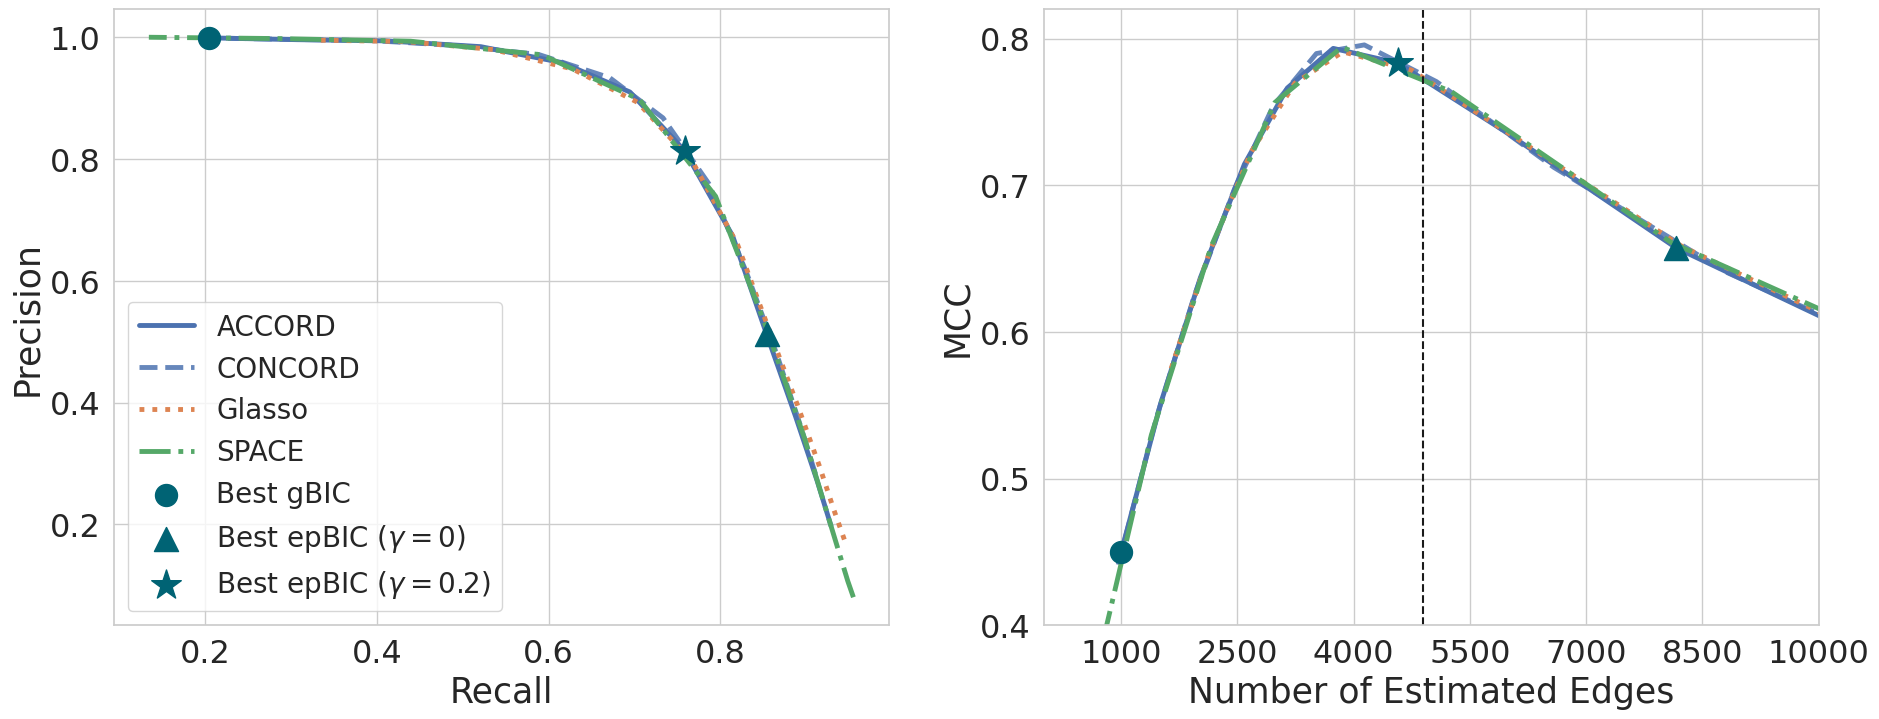

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(accord_recalls, accord_precs, linewidth=3.5, color='C0', label='ACCORD')
axes[i].plot(concord_recalls, concord_precs, linewidth=3.5, linestyle='--', color='C0', alpha=0.85, label='CONCORD')
axes[i].plot(glasso_recalls, glasso_precs, linewidth=3.5, linestyle=':', color='C1', label='Glasso')
axes[i].plot(space_recalls, space_precs, linewidth=3.5, linestyle='-.', color='C2', label='SPACE')
axes[i].scatter(accord_recalls[best_g_bic], accord_precs[best_g_bic], marker='o', zorder=2, s=250, color=sns.color_palette('dark')[-1], label='Best gBIC')
axes[i].scatter(accord_recalls[best_p_bic], accord_precs[best_p_bic], marker='^', zorder=2, s=300, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0$)')
axes[i].scatter(accord_recalls[best_ep_bic_02], accord_precs[best_ep_bic_02], marker='*', zorder=2, s=500, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0.2$)')
axes[i].set_xlabel('Recall', fontsize=25)
axes[i].set_ylabel('Precision', fontsize=25)
axes[i].tick_params(axis='both', which='major', labelsize=23)
axes[i].legend(fontsize=20, loc='lower left')

i = 1
axes[i].plot(accord_edges, accord_mccs, linewidth=3.5, color='C0', label='ACCORD')
axes[i].plot(concord_edges, concord_mccs, linewidth=3.5, linestyle='--', color='C0', alpha=0.85, label='CONCORD')
axes[i].plot(glasso_edges, glasso_mccs, linewidth=3.5, linestyle=':', color='C1', label='Glasso')
axes[i].plot(space_edges, space_mccs, linewidth=3.5, linestyle='-.', color='C2', label='SPACE')
axes[i].scatter(accord_edges[best_g_bic], accord_mccs[best_g_bic], marker='o', zorder=2, s=250, color=sns.color_palette('dark')[-1], label='Best gBIC')
axes[i].scatter(accord_edges[best_p_bic], accord_mccs[best_p_bic], marker='^', zorder=2, s=300, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0$)')
axes[i].scatter(accord_edges[best_ep_bic_02], accord_mccs[best_ep_bic_02], marker='*', zorder=2, s=500, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0.2$)')
axes[i].axvline((len(np.flatnonzero(Theta))-p)/2, linewidth=1.5, color='k', linestyle='--')
axes[i].set_xlabel('Number of Estimated Edges', fontsize=25)
axes[i].set_ylabel('MCC', fontsize=25)
axes[i].tick_params(axis='both', which='major', labelsize=23)
if graph_structure == 'hub_network':
    axes[i].set_xlim((300,5000))
    axes[i].set_ylim((0.35,0.59))
    axes[i].set_xticks(np.arange(500, 6500, 1000))
elif graph_structure == 'erdos_renyi':
    axes[i].set_xlim((0,3000))
    axes[i].set_ylim((0.4,0.82))
    axes[i].set_xticks(np.arange(1000, 10500, 1500))
    axes[i].set_yticks(np.linspace(0.4, 0.8, 5))

plt.savefig('../output/diag[1,3]_edge_detection_' + graph_structure + '.png', bbox_inches='tight');

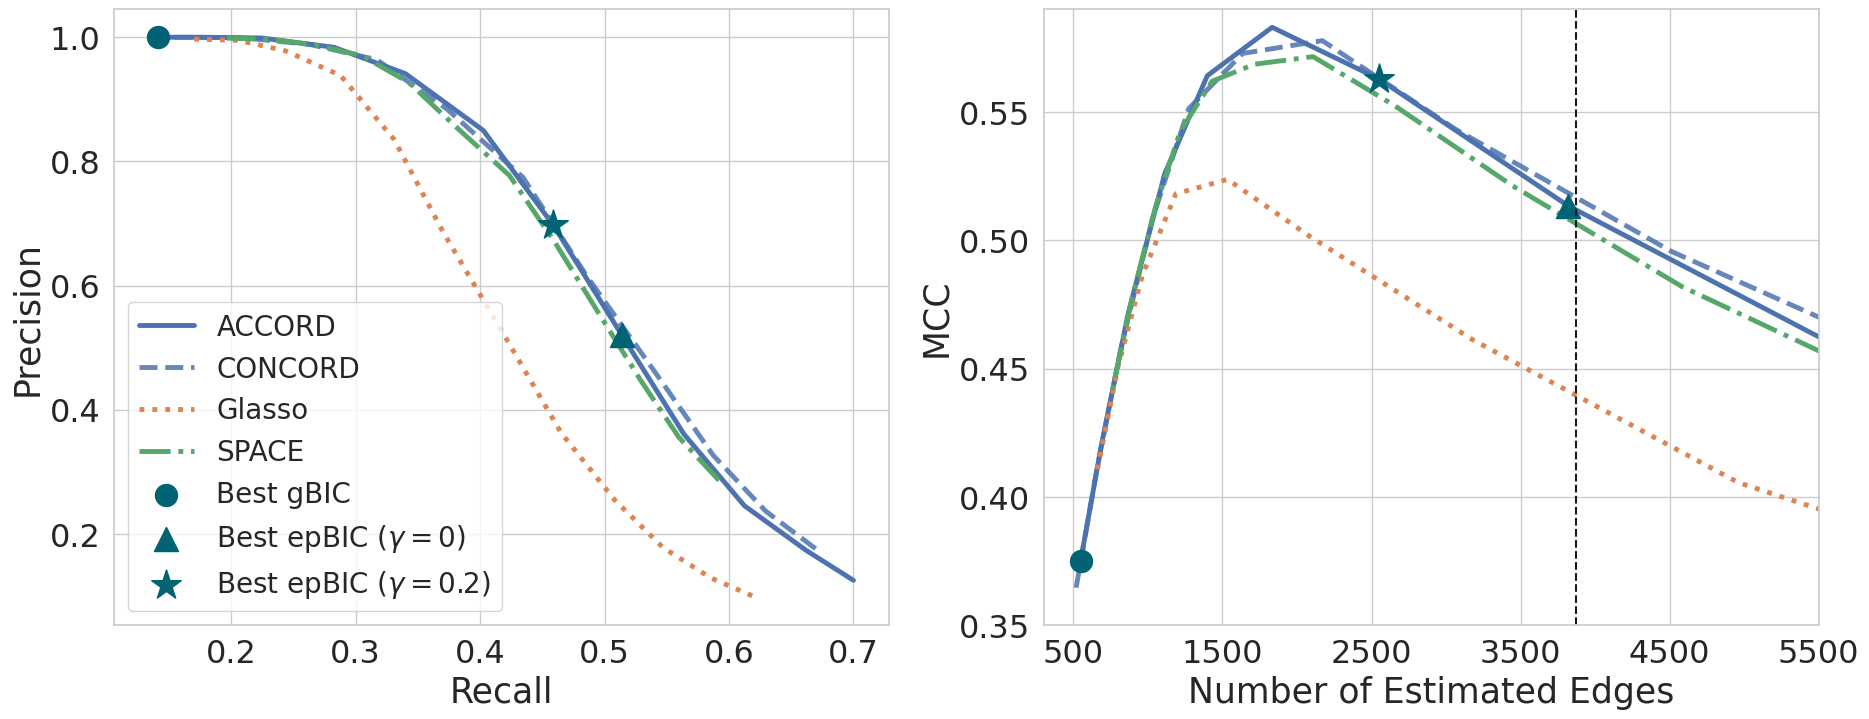

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(accord_recalls, accord_precs, linewidth=3.5, color='C0', label='ACCORD')
axes[i].plot(concord_recalls, concord_precs, linewidth=3.5, linestyle='--', color='C0', alpha=0.85, label='CONCORD')
axes[i].plot(glasso_recalls, glasso_precs, linewidth=3.5, linestyle=':', color='C1', label='Glasso')
axes[i].plot(space_recalls, space_precs, linewidth=3.5, linestyle='-.', color='C2', label='SPACE')
axes[i].scatter(accord_recalls[best_g_bic], accord_precs[best_g_bic], marker='o', zorder=2, s=250, color=sns.color_palette('dark')[-1], label='Best gBIC')
axes[i].scatter(accord_recalls[best_p_bic], accord_precs[best_p_bic], marker='^', zorder=2, s=300, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0$)')
axes[i].scatter(accord_recalls[best_ep_bic_02], accord_precs[best_ep_bic_02], marker='*', zorder=2, s=500, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0.2$)')
axes[i].set_xlabel('Recall', fontsize=25)
axes[i].set_ylabel('Precision', fontsize=25)
axes[i].tick_params(axis='both', which='major', labelsize=23)
axes[i].legend(fontsize=20, loc='lower left')

i = 1
axes[i].plot(accord_edges, accord_mccs, linewidth=3.5, color='C0', label='ACCORD')
axes[i].plot(concord_edges, concord_mccs, linewidth=3.5, linestyle='--', color='C0', alpha=0.85, label='CONCORD')
axes[i].plot(glasso_edges, glasso_mccs, linewidth=3.5, linestyle=':', color='C1', label='Glasso')
axes[i].plot(space_edges, space_mccs, linewidth=3.5, linestyle='-.', color='C2', label='SPACE')
axes[i].scatter(accord_edges[best_g_bic], accord_mccs[best_g_bic], marker='o', zorder=2, s=250, color=sns.color_palette('dark')[-1], label='Best gBIC')
axes[i].scatter(accord_edges[best_p_bic], accord_mccs[best_p_bic], marker='^', zorder=2, s=300, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0$)')
axes[i].scatter(accord_edges[best_ep_bic_02], accord_mccs[best_ep_bic_02], marker='*', zorder=2, s=500, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0.2$)')
axes[i].axvline((len(np.flatnonzero(Theta))-p)/2, linewidth=1.5, color='k', linestyle='--')
axes[i].set_xlabel('Number of Estimated Edges', fontsize=25)
axes[i].set_ylabel('MCC', fontsize=25)
axes[i].tick_params(axis='both', which='major', labelsize=23)
if graph_structure == 'hub_network':
    axes[i].set_xlim((300,5000))
    axes[i].set_ylim((0.35,0.59))
    axes[i].set_xticks(np.arange(500, 6500, 1000))
elif graph_structure == 'erdos_renyi':
    axes[i].set_xlim((0,3000))
    axes[i].set_ylim((0.32,0.82))
    axes[i].set_xticks(np.arange(1000, 9500, 1500))
    axes[i].set_yticks(np.linspace(0.4, 0.8, 5))

plt.savefig('../output/diag[1,3]_edge_detection_' + graph_structure + '.png', bbox_inches='tight');

### Estimation error comparison

In [9]:
accord_ep_bics_02 = np.genfromtxt('new_data/' + graph_structure + '_accord_ep_bics_02.txt', delimiter=',')
concord_ep_bics_02 = np.genfromtxt('new_data/' + graph_structure + '_concord_ep_bics_02.txt', delimiter=',')
glasso_g_bics = np.genfromtxt('new_data/' + graph_structure + '_glasso_g_bics.txt', delimiter=',')
space_ep_bics_02 = np.genfromtxt('new_data/' + graph_structure + '_space_ep_bics_02.txt', delimiter=',')

S = np.matmul(X.T, X)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
if graph_structure == 'hub_network':
    lams = lams[::-1][14:26] # pre-selected lambdas for hub network
elif graph_structure == 'erdos_renyi':
    # lams = lams[::-1][7:19] # pre-selected lambdas for erdos renyi
    lams = lams[::-1][8:20] # pre-selected lambdas for erdos renyi (diag=[1, 3])

best_lam_accord = lams[np.argmin(accord_ep_bics_02)]
best_lam_concord = lams[np.argmin(concord_ep_bics_02)]
best_lam_glasso = lams[np.argmin(glasso_g_bics)]

if graph_structure == 'hub_network':
    lams = np.logspace(np.log10(100), np.log10(200), 12) # pre-selected lambdas for hub network
elif graph_structure == 'erdos_renyi':
    lams = np.logspace(np.log10(50), np.log10(250), 12) # pre-selected lambdas for erdos renyi
    
best_lam_space = lams[np.argmin(space_ep_bics_02)]

In [10]:
# accord biased
model = GraphicalAccord(Omega_star=np.eye(p), lam1=best_lam_accord, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=100)
model.fit(X)
Omega_hat = model.omega_.toarray()
Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
Rho_hat = partial_corr(Theta_hat)
l1_norm_accord = np.sum(np.abs(Rho_hat - Rho))
fro_norm_accord = np.linalg.norm(Rho_hat - Rho)

# accord debiased with newton one-step
S = np.matmul(X.T, X)/n
T_hat = newton_one_step(S, Omega_hat)
T_hat[Omega_hat == 0] = 0
Theta_hat_newton = 0.5 * ((np.diag(np.diag(T_hat)) @ T_hat) + (T_hat.T @ np.diag(np.diag(T_hat))))
Rho_hat_newton = partial_corr(Theta_hat_newton)
l1_norm_accord_newton = np.sum(np.abs(Rho_hat_newton - Rho))
fro_norm_accord_newton = np.linalg.norm(Rho_hat_newton - Rho)

# accord debiased with refitting
lam_mat = np.where(Omega_hat != 0, 0, 1000.0)
model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam_mat, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=100)
model.fit(X)
Omega_hat_refitted = model.omega_.toarray()
Theta_hat_refitted = 0.5 * ((np.diag(np.diag(Omega_hat_refitted)) @ Omega_hat_refitted) + (Omega_hat_refitted.T @ np.diag(np.diag(Omega_hat_refitted))))
Rho_hat_refitted = partial_corr(Theta_hat_refitted)
l1_norm_accord_refitted = np.sum(np.abs(Rho_hat_refitted - Rho))
fro_norm_accord_refitted = np.linalg.norm(Rho_hat_refitted - Rho)

In [11]:
# refit concord
model = GraphicalConcord(Omega_star=np.eye(p), lam1=best_lam_concord, backtracking=True, epstol=1e-7, maxitr=100)
model.fit(X)
Theta_hat = model.omega_.toarray()
Rho_hat = partial_corr(Theta_hat)
l1_norm_concord = np.sum(np.abs(Rho_hat - Rho))
fro_norm_concord = np.linalg.norm(Rho_hat - Rho)

In [12]:
# refit glasso
quic = QuicGraphicalLasso(lam=best_lam_glasso, max_iter=100).fit(X)
Theta_hat = quic.precision_
Rho_hat = partial_corr(Theta_hat)
l1_norm_glasso = np.sum(np.abs(Rho_hat - Rho))
fro_norm_glasso = np.linalg.norm(Rho_hat - Rho)

In [13]:
%%capture

# refit space
rpy2.robjects.numpy2ri.activate()
space = importr('space')

prec = space.space_joint(X, np.array([best_lam_space]))
Theta_hat = np.array(prec[0])
Rho_hat = partial_corr(Theta_hat)
l1_norm_space = np.sum(np.abs(Rho_hat - Rho))
fro_norm_space = np.linalg.norm(Rho_hat - Rho)

In [14]:
# hub network diag=[1, 3]
print('ACCORD (biased)')
print('l1 norm:', l1_norm_accord)
print('fro. norm:', fro_norm_accord, '\n')
print('ACCORD (Newton one-step)')
print('l1 norm:', l1_norm_accord_newton)
print('fro. norm:', fro_norm_accord_newton, '\n')
print('ACCORD (refitted)')
print('l1 norm:', l1_norm_accord_refitted)
print('fro. norm:', fro_norm_accord_refitted, '\n')
print('CONCORD')
print('l1 norm:', l1_norm_concord)
print('fro. norm:', fro_norm_concord, '\n')
print('Glasso')
print('l1 norm:', l1_norm_glasso)
print('fro. norm:', fro_norm_glasso, '\n')
print('SPACE')
print('l1 norm:', l1_norm_space)
print('fro. norm:', fro_norm_space)

ACCORD (biased)
l1 norm: 1338.6633203356037
fro. norm: 18.097151980905178 

ACCORD (Newton one-step)
l1 norm: 1115.8953774684815
fro. norm: 14.627089787486787 

ACCORD (refitted)
l1 norm: 1002.2100511566223
fro. norm: 13.394607215592368 

CONCORD
l1 norm: 1342.1630072401579
fro. norm: 18.163966459306902 

Glasso
l1 norm: 1539.2484824336057
fro. norm: 20.95796754839977 

SPACE
l1 norm: 1771.0393386390638
fro. norm: 24.924746662078864


In [23]:
# erdos renyi diag=[1, 3]
print('ACCORD (biased)')
print('l1 norm:', l1_norm_accord)
print('fro. norm:', fro_norm_accord, '\n')
print('ACCORD (Newton one-step)')
print('l1 norm:', l1_norm_accord_newton)
print('fro. norm:', fro_norm_accord_newton, '\n')
print('ACCORD (refitted)')
print('l1 norm:', l1_norm_accord_refitted)
print('fro. norm:', fro_norm_accord_refitted, '\n')
print('CONCORD')
print('l1 norm:', l1_norm_concord)
print('fro. norm:', fro_norm_concord, '\n')
print('Glasso')
print('l1 norm:', l1_norm_glasso)
print('fro. norm:', fro_norm_glasso, '\n')
print('SPACE')
print('l1 norm:', l1_norm_space)
print('fro. norm:', fro_norm_space)

ACCORD (biased)
l1 norm: 959.6165581272287
fro. norm: 10.138715452083002 

ACCORD (Newton one-step)
l1 norm: 641.4426163857609
fro. norm: 7.527224860353091 

ACCORD (refitted)
l1 norm: 635.5778648768679
fro. norm: 7.496205652110933 

CONCORD
l1 norm: 910.7005759416908
fro. norm: 9.56522927956677 

Glasso
l1 norm: 1257.1852522324514
fro. norm: 13.11585438793763 

SPACE
l1 norm: 1419.0536176353987
fro. norm: 14.997714407973719


In [10]:
# hub network
print('ACCORD (biased)')
print('l1 norm:', l1_norm_accord)
print('fro. norm:', fro_norm_accord, '\n')
print('ACCORD (Newton one-step)')
print('l1 norm:', l1_norm_accord_newton)
print('fro. norm:', fro_norm_accord_newton, '\n')
print('ACCORD (refitted)')
print('l1 norm:', l1_norm_accord_refitted)
print('fro. norm:', fro_norm_accord_refitted, '\n')
print('CONCORD')
print('l1 norm:', l1_norm_concord)
print('fro. norm:', fro_norm_concord, '\n')
print('Glasso')
print('l1 norm:', l1_norm_glasso)
print('fro. norm:', fro_norm_glasso, '\n')
print('SPACE')
print('l1 norm:', l1_norm_space)
print('fro. norm:', fro_norm_space)

ACCORD (biased)
l1 norm: 1344.678246026369
fro. norm: 18.156938643767038 

ACCORD (Newton one-step)
l1 norm: 1131.8052534049243
fro. norm: 14.757003428076267 

ACCORD (refitted)
l1 norm: 1027.2151119992643
fro. norm: 13.626144339338234 

CONCORD
l1 norm: 1347.3094151126024
fro. norm: 18.215426447642248 

Glasso
l1 norm: 1541.357689926916
fro. norm: 20.968618292615954 

SPACE
l1 norm: 1769.7246043183357
fro. norm: 24.90403132615543


In [22]:
# erdos renyi
print('ACCORD (biased)')
print('l1 norm:', l1_norm_accord)
print('fro. norm:', fro_norm_accord, '\n')
print('ACCORD (Newton one-step)')
print('l1 norm:', l1_norm_accord_newton)
print('fro. norm:', fro_norm_accord_newton, '\n')
print('ACCORD (refitted)')
print('l1 norm:', l1_norm_accord_refitted)
print('fro. norm:', fro_norm_accord_refitted, '\n')
print('CONCORD')
print('l1 norm:', l1_norm_concord)
print('fro. norm:', fro_norm_concord, '\n')
print('Glasso')
print('l1 norm:', l1_norm_glasso)
print('fro. norm:', fro_norm_glasso, '\n')
print('SPACE')
print('l1 norm:', l1_norm_space)
print('fro. norm:', fro_norm_space)

ACCORD (biased)
l1 norm: 966.8265923753081
fro. norm: 10.204322747413018 

ACCORD (Newton one-step)
l1 norm: 651.1323716441073
fro. norm: 7.58435904573465 

ACCORD (refitted)
l1 norm: 645.6342759566139
fro. norm: 7.555746772486645 

CONCORD
l1 norm: 918.9526614872956
fro. norm: 9.635026200232431 

Glasso
l1 norm: 1263.0216626907809
fro. norm: 13.168189890472567 

SPACE
l1 norm: 1415.6857342213686
fro. norm: 14.947304456041506
